## Load Data

In [1]:
import mxnet as mx
import logging
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
%matplotlib inline

sns.set()
mnist = mx.test_utils.get_mnist()

In [2]:
batch_size = 100
train_iter = mx.io.NDArrayIter(mnist['train_data'], mnist['train_label'], batch_size, shuffle=True)
val_iter = mx.io.NDArrayIter(mnist['test_data'], mnist['test_label'], batch_size)

## Model

In [3]:
data = mx.sym.var('data')
# Flatten the data from 4-D shape into 2-D (batch_size, num_channel*width*height)
data = mx.sym.flatten(data=data)
true_labels = mx.sym.var('softmax_label')

In [4]:
# The first fully-connected layer and the corresponding activation function
fc1  = mx.sym.FullyConnected(data=data, num_hidden=128, name='fc1')
act1 = mx.sym.Activation(data=fc1, act_type="relu", name='relu1')

# The second fully-connected layer and the corresponding activation function
fc2  = mx.sym.FullyConnected(data=act1, num_hidden = 64, name='fc2')
act2 = mx.sym.Activation(data=fc2, act_type="relu", name='relu2')

# MNIST has 10 classes
fc3  = mx.sym.FullyConnected(data=act2, num_hidden=10, name='fc3')
# Compute softmax
softmax_out  = mx.sym.softmax(data=fc3, name='softmax_out')
#y_hat = mx.sym.argmax(softmax_out)
one_hot = mx.sym.one_hot(true_labels, depth=10, name='one_hot')
epsilon = 1e-8
ce = mx.sym.sum(- one_hot * mx.sym.log(epsilon + softmax_out))

In [5]:
my_loss = mx.sym.MakeLoss(ce)
group = mx.sym.Group([mx.sym.BlockGrad(softmax_out, name='softmax'), my_loss])

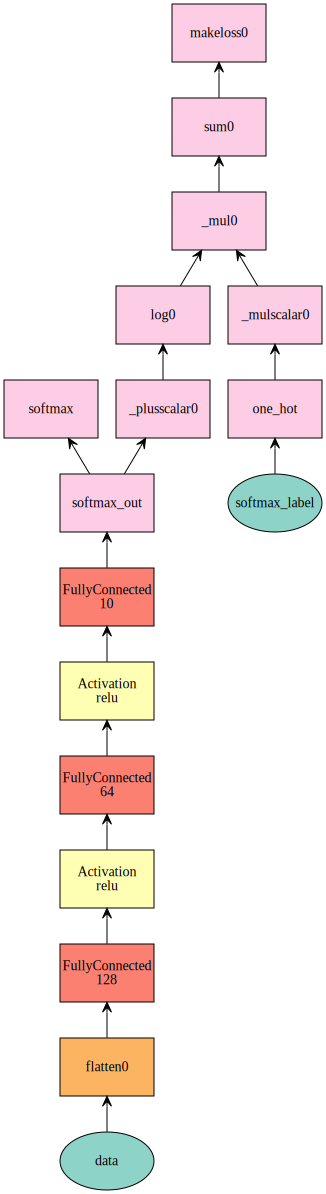

In [6]:
mx.viz.plot_network(symbol=group)

## Training

### Basic MLP model

In [7]:
mod_1 = mx.mod.Module(symbol=group, context=mx.cpu(), data_names=['data'], label_names=['softmax_label'])
mod_1.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod_1.init_params(initializer=mx.init.Uniform(scale=.1))
mod_1.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate': 0.1})
metrics = mx.metric.CompositeEvalMetric([mx.metric.Accuracy(), mx.metric.CrossEntropy()], output_names='softmax_output')

In [8]:
epochs = 50

In [9]:
mod_1_tr_acc = []
mod_1_val_acc = []
for epoch in range(epochs):
    ## Training
    for batch in train_iter:
        mod_1.forward(batch, is_train=True)       # compute predictions
        mod_1.update_metric(metrics, batch.label)  # accumulate prediction accuracy
        mod_1.backward()                          # compute gradients
        mod_1.update()                            # update parameters
        loss = mod_1.get_outputs()[1].asnumpy()
        # print('Epoch %d, Loss %.3f' % (epoch, loss[1].asnumpy()))
    for name, val in metrics.get_name_value():
        logging.warning('Epoch [%d] Train-%s=%f' % (epoch, name, val))
        if name == 'accuracy':
            mod_1_tr_acc.append(val)
    
    train_iter.reset()
    metrics.reset()
    
    eval_results = mod_1.predict(val_iter)
    eval_probability = eval_results[0].asnumpy()
    eval_prediction = np.argmax(eval_probability, axis=1)
    eval_accuracy = accuracy_score(eval_prediction, mnist['test_label'])
    logging.warning('Epoch [%d] Validation-%s=%f' % (epoch, 'accuracy', eval_accuracy))
    mod_1_val_acc.append(eval_accuracy)
    

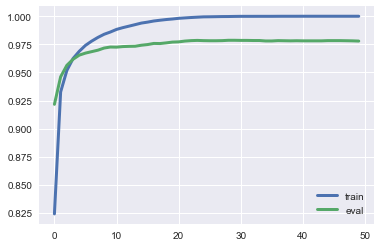

In [10]:
## Plot
plt.plot(range(epochs), mod_1_tr_acc, linewidth=3, label='train')
plt.plot(range(epochs), mod_1_val_acc, linewidth=3, label='eval')
plt.legend(loc=4)

### L2 Regularization

In [11]:
mod_2 = mx.mod.Module(symbol=group, context=mx.cpu(), data_names=['data'], label_names=['softmax_label'])
mod_2.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod_2.init_params(initializer=mx.init.Uniform(scale=.1))
mod_2.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate': 0.1, 'wd': 0.001})

In [12]:
mod_2_tr_acc = []
mod_2_val_acc = []
for epoch in range(epochs):
    ## Training
    for batch in train_iter:
        mod_2.forward(batch, is_train=True)       # compute predictions
        mod_2.update_metric(metrics, batch.label)  # accumulate prediction accuracy
        mod_2.backward()                          # compute gradients
        mod_2.update()                            # update parameters
        loss = mod_2.get_outputs()[1].asnumpy()
        # print('Epoch %d, Loss %.3f' % (epoch, loss[1].asnumpy()))
    for name, val in metrics.get_name_value():
        logging.warning('Epoch [%d] Train-%s=%f' % (epoch, name, val))
        if name == 'accuracy':
            mod_2_tr_acc.append(val)
    
    train_iter.reset()
    metrics.reset()
    
    eval_results = mod_2.predict(val_iter)
    eval_probability = eval_results[0].asnumpy()
    eval_prediction = np.argmax(eval_probability, axis=1)
    eval_accuracy = accuracy_score(eval_prediction, mnist['test_label'])
    logging.warning('Epoch [%d] Validation-%s=%f' % (epoch, 'accuracy', eval_accuracy))
    mod_2_val_acc.append(eval_accuracy)

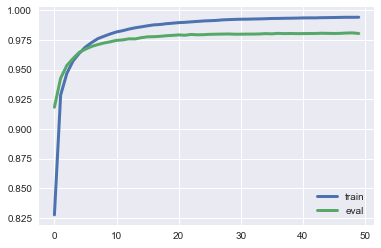

In [13]:
## Plot
plt.plot(range(epochs), mod_2_tr_acc, linewidth=3, label='train')
plt.plot(range(epochs), mod_2_val_acc, linewidth=3, label='eval')
plt.legend(loc=4)

### L1 Regularization

In [31]:
l1 = 0
for i in range(1, 4):
    l1 += mx.sym.sum(mx.sym.abs(ce.get_internals()['fc%d_weight'%i]))

loss = ce + 0.0005*l1

my_loss = mx.sym.MakeLoss(loss)
group = mx.sym.Group([mx.sym.BlockGrad(softmax_out, name='softmax'), my_loss])

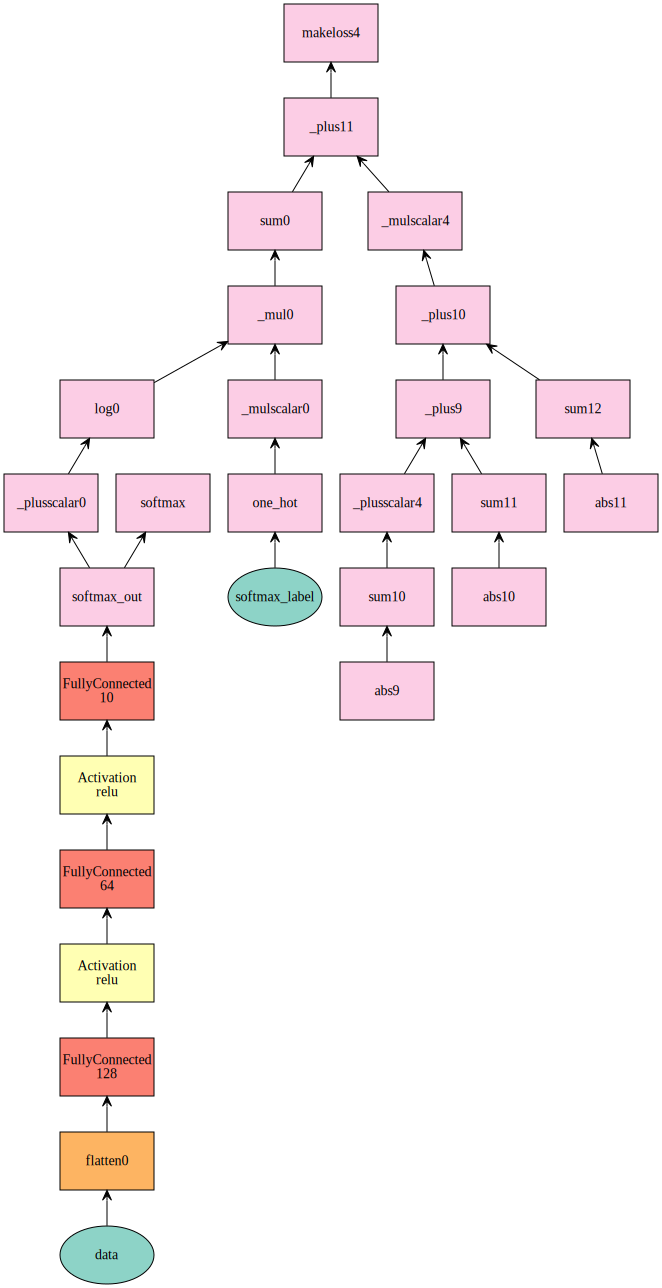

In [32]:
mx.viz.plot_network(symbol=group)

In [ ]:
mod_3 = mx.mod.Module(symbol=group, context=mx.cpu(), data_names=['data'], label_names=['softmax_label'])
mod_3.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod_3.init_params(initializer=mx.init.Uniform(scale=.1))
mod_3.init_optimizer(optimizer='sgd', optimizer_params={'learning_rate': 0.1})

In [ ]:
mod_3_tr_acc = []
mod_3_val_acc = []
for epoch in range(epochs):
    ## Training
    for batch in train_iter:
        mod_3.forward(batch, is_train=True)       # compute predictions
        mod_3.update_metric(metrics, batch.label)  # accumulate prediction accuracy
        mod_3.backward()                          # compute gradients
        mod_3.update()                            # update parameters
        loss = mod_2.get_outputs()[1].asnumpy()
        # print('Epoch %d, Loss %.3f' % (epoch, loss[1].asnumpy()))
    for name, val in metrics.get_name_value():
        logging.warning('Epoch [%d] Train-%s=%f' % (epoch, name, val))
        if name == 'accuracy':
            mod_3_tr_acc.append(val)
    
    train_iter.reset()
    metrics.reset()
    
    eval_results = mod_3.predict(val_iter)
    eval_probability = eval_results[0].asnumpy()
    eval_prediction = np.argmax(eval_probability, axis=1)
    eval_accuracy = accuracy_score(eval_prediction, mnist['test_label'])
    logging.warning('Epoch [%d] Validation-%s=%f' % (epoch, 'accuracy', eval_accuracy))
    mod_3_val_acc.append(eval_accuracy)

In [ ]:
plt.plot(range(epochs), mod_3_tr_acc, linewidth=3, label='train')
plt.plot(range(epochs), mod_3_val_acc, linewidth=3, label='eval')
plt.legend(loc=4)

In [ ]:
plt.figure(figsize=(16,12))
plt.plot(range(epochs), mod_1_tr_acc, linewidth=3, label='train-basic')
plt.plot(range(epochs), mod_2_tr_acc, linewidth=3, label='train-L2')
plt.plot(range(epochs), mod_3_tr_acc, linewidth=3, label='train-L1')
plt.plot(range(epochs), mod_1_val_acc, linewidth=3, label='eval-basic')
plt.plot(range(epochs), mod_2_val_acc, linewidth=3, label='eval-L2')
plt.plot(range(epochs), mod_3_val_acc, linewidth=3, label='eval-L1')
plt.legend(loc=4)